# Mechanics Applications in FEniCS

This lecture is based on the [FEniCS tutorials](https://fenicsproject.org/pub/tutorial/html/._ftut1001.html#table_of_contents).

In [1]:
%matplotlib inline

| <img src="figures/heart.jpg" width=250> |
|:--:|
| *The heart is perfused by thousands of small blood vessels. Photo of a resin cast by Arno Massee* |

Oxygen and other nutrients are vital supplies for tissue function in general and are delivered via the cardiovascular system. The arteries supplying tissue branch into thousands of small arteries, arterioles and capillaries that are impossible to capture using modern imaging techniques. However, averaging over entire blocks of tissue allows us to approximate perfusion as a spongy material and to thus exploit porous continuum models.

## Tissue perfusion: Darcy's law

The previous lecture introduced porous flow in the form of Darcy's law. In its reduced form Darcy's law reads

$$\nabla \cdot \left( -\boldsymbol{K} \; \nabla p(\boldsymbol{x}) \right) = f(\boldsymbol{x}) \qquad \text{on } \Omega$$

augmented by some Dirichlet boundary conditions

$$p(\boldsymbol{x}) = p_D(\boldsymbol{x}) \qquad \text{on } \partial \Omega$$

In this equation we solve for the unknown pressure $p$ only. Velocity a calculated from the result as

$$u = -\boldsymbol{K} \; \nabla p(\boldsymbol{x}) \qquad \text{on } \Omega$$

Note that $u$ is the velocity of fluid _within a pore_. To obtain velocity on the tissue scale, $u$ has to be scaled by the tissue's porosity

$$\bar{u} = \phi u$$

Darcy's law itself is a stationary problem (no time dependence). However, in mechanics applications, and for biological systems in particular, we are most often interested in solving time-dependent problems. Darcy's law becomes time-dependent when either $p_D$ or $f(x)$ (or both!) are functions of time. In this case, each timestep is solved as a stationary sub-problem, while $p_D$ and/or $f(x)$ are updated at the beginning of each timestep. We can thus easily expand our code for solving Darcy's law.

### FEniCS implementation

In [7]:
from fenics import *
import numpy as np

We first set up the problem parameters and variational forms

In [8]:
# Create mesh and define function space
n = 32
mesh = UnitSquareMesh(n, n)
W = FunctionSpace(mesh, 'P', 1) # pressure space
V = VectorFunctionSpace(mesh, 'P', 2)

# Define permeability and porosity
kmin = 0.01
K = Expression('max(exp(-pow((x[1]-0.5-0.1*sin(10*x[0]))/0.1, 2)), 0.01)', degree=1)
phi = Constant(0.2)

# Define boundary condition
pD = Expression('(1-x[0])*t', t=0.0, degree=1)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(W, pD, boundary)

# Define variational problem
p = TestFunction(W)
q = TrialFunction(W)
f = Constant(0.0)
n = FacetNormal(mesh)
a = K * inner(grad(p), grad(q))*dx
L = f*q*dx

We will use the XDMF file format to store results. An example of how an XDMF file can store a function is shown below:

In [9]:
p = Function(W)
t = 0.0
file = XDMFFile("perfusion/test.xdmf")
# do some stuff
file.write_checkpoint(p, 'pressure', t, append=False)
# do some more stuff
file.close()

The function write_checkpoint() takes 3 arguments, plus one optional argument. The arguments are the FEniCS Function to be stored, a label for the function, and time. The optional argument can be used to set the file write mode to "append" (default append=False). Files are closed at the very end of the code.

#### Exercise: Complete the code

Complete the code below such that the variational form above is solved until $t = 1.0$ using the given time step size. Store $p$ and $u$ in the corresponding XDMF file during each time step. XDMF files can be postprocessed / viewed in [Paraview](https://www.paraview.org/).

In [10]:
p_file = XDMFFile("perfusion/p.xdmf")
u_file = XDMFFile("perfusion/u.xdmf")

# Compute solution
dt = 0.1
t = 0.0
append = False
p = Function(W)
u = Function(V)

# Insert code here
    
p_file.close()
u_file.close()

#### Exercise: Visualisation in Paraview

- Opening files
- Visualising scalar quantities
- Visualising vector quantities
- Using filters

#### Exercise: Error analysis

## Tracking tracers: Advection-diffusion-reaction equations

While fluid pressure and velocity within biological tissues are interesting quantities in their own respect, it is often particularly interesting to know how tracer molecules distribute through the tissue, driven by fluid dynamics. This is achieved via a system of advection-diffusion-reaction equations.

## Elastic deformation: Linear elasticity

Linear elasticity deals with the equations governing small elastic deformations following a linear relationship between stress and strain. Nonlinear stress-strain relationships are goverened by the hyperelastic equations, which are introduced in the Cardiac Tissue Mechanics and Fluid Dynamics stream of the Summer School.

The momentum balance equation for small elastic deformations of a body $\Omega$ reads

$$-\nabla \cdot \sigma = f \qquad \text{in } \Omega$$

with stress tensor $\sigma$, elasticity tensor $\varepsilon$ and body force per unit volume $f(\boldsymbol{x})$. 

$$\sigma = \lambda \; tr(\varepsilon) I + 2 \mu \varepsilon$$
$$\varepsilon = \frac{1}{2} (\nabla u + (\nabla u)^T)$$

The stress tensor depends on two parameters that are specific for every material, the Lamè constants $\lambda$ and $\mu$. The trace operator $tr(A)$ represents the sum of the elements on the main diagonal of a tensor $A$, $I$ is the identity tensor, and $u(\boldsymbol{x})$ is the displacement vector field. Inserting the definition of $\varepsilon$ into $\sigma$ gives

$$\sigma = \lambda (\nabla \cdot u) I + \mu (\nabla u + (\nabla u)^T)$$

Note that while we have written the momentum balance equation in terms of the stress tensor $\sigma$, our primary unknown is the displacement vector field $u$.

### Variational form

Deriving the variational form requires multiplication of the governing equation by a test function $v \in \hat{V}$, integrating over the domain $\Omega$.

$$- \int_{\Omega} (\nabla \cdot \sigma) \cdot v dx = \int_{\Omega} f \cdot v dx$$

Note that this time, as our unknown $u$ is vector-valued, our test function $v$ is also vector-valued. Note also from the definition of $\sigma$ that the term $\nabla \cdot \sigma$ contains second-order derivatives of $u$, so we integrate this term by parts

$$- \int_{\Omega} (\nabla \cdot \sigma) \cdot v dx = \int_{\Omega} \sigma : \nabla v dx - \int_{\partial \Omega} (\sigma \cdot n) \cdot v ds$$

where the colon operator denotes the *inner product* between two tensors:

$$A : B = \sum_i \sum_j A_{ij} B_{ij} = A_{11} B_{11} + A_{12} B_{12} + \ldots$$

The term $\sigma \cdot n$ denotes traction or stress at the boundary in the outward normal direction of the boundary and is often prescribed as a boundary condition. In fluid-structure interaction problems such as the deformation of an arterial wall due to the oscillating blood pressure, the boundary traction is directly proportional to the fluid pressure $\sigma \cdot n = -p n$. Here, we assume that traction is prescribed on some part $\partial \Omega_T$ of the boundary as $\sigma \cdot n = T$. On the remaining boundary we assume that displacement is prescribed using a Dirichlet boundary condition. The variational form thus reads

$$\int_{\Omega} \sigma : \nabla v dx = \int_{\Omega} f \cdot v dx - \int_{\partial \Omega_T} T \cdot v ds$$

or

$$a(u,v) = L(v) \qquad \forall v \in \hat{V}$$

where

$$a(u,v) = \int_{\Omega} \sigma : \nabla v dx$$
$$\sigma = \lambda (\nabla \cdot u) I + \mu (\nabla u + (\nabla u)^T)$$
$$L(v) = \int_{\Omega} f \cdot v dx - \int_{\partial \Omega_T} T \cdot v ds$$

The inner product of a symmetric tensor $A$ with an antisymmetric tensor $B$ vanishes. By expressing $\nabla v$ as a sum of its symmetric and antisymmetric parts it is thus possible to simplify the term $\sigma : \nabla v$ since $\sigma$ is always a symmetric tensor to obtain

$$a(u,v) = \int_{\Omega} \sigma : \varepsilon(v) dx$$

where

$$\varepsilon(v) = \frac{1}{2} (\nabla v + (\nabla v)^T)$$

is the symmetric part of $\nabla v$.

### FEniCS implementation

In [12]:
from fenics import *
from ufl import nabla_div
from mshr import *

import numpy as np
import matplotlib.pylab as plt

As an example, we will consider the elastic deformation of the wall of an artery, represented by an axisymmetric cylindrical tube. 

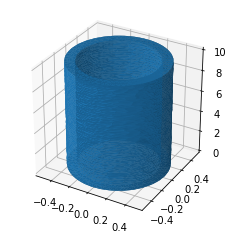

In [18]:
# Create mesh and define function space
L = 10
W_i = 0.4
W_o = 0.5
c1 = Cylinder(Point(0,0,0), Point(0,0,L), W_o, W_o)
c2 = Cylinder(Point(0,0,0), Point(0,0,L), W_i, W_i)
geo = c1-c2
mesh = generate_mesh(geo, 32)
plot(mesh)
V = VectorFunctionSpace(mesh, 'P', 1)

# Define elasticity parameters
mu = 1
lam = 10

We have previously implemented Dirichlet boundary conditions using functions, and while functions work well for Dirichlet boundary conditions, we can't implement Neumann boundary conditions in this way. A more general approach to implementing boundary conditions is provided using a MeshFunction. A MeshFunction allows you to mark parts of a domain's boundary using labels that can then be used to apply boundary conditions.

In [19]:
# Instantiate a boundary MeshFunction using integers as lables
boundaries = MeshFunction('size_t', mesh, mesh.topology().dim()-1)
boundaries.set_all(0)

Boundary conditions now have to be implemented as a class inheriting from the FEniCS class SubDomain

In [20]:
class Pressure(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[2], 0.2)

pressure = Pressure()
pressure.mark(boundaries, 1)

To apply the boundary conditions we write

In [24]:
u_D = Constant((0.0, 0.0, 0.0))

# Applying Dirichlet conditions:
bc = DirichletBC(V, u_D, boundaries, 1)

# Applying Neumann conditions.
ds = ds(subdomain_data=boundaries)

# Example variational form applying a Neumann condition to the 
# boundary labelled '1' using ds()
# L = f*ds(1)

#### Exercise: Implement suitable boundary conditions.

Implement a traction boundary condition that applies varying pressure over time

$$p_N = 1000 \cdot (1 - \exp(-t^2/0.25))$$

and ensure that the ends of the artery wall are fixed in space, such that



In [ ]:
# Define Dirichlet boundary condition

# insert code here

# Define Neumann boundary condition

# insert code here

In [ ]:
# Define strain and stress
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)

def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

#### Exercise: Implement the variational form for the linear elastic problem. Fluid pressure in the artery is 80 mmHg $\approx$ 10500 Pa on the inner boundary of the wall

In [14]:
# Define variational problem
# insert code here
a = 0
L = 0

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Save solution
u_file = XDMFFile("linear_elasticity/du.xdmf")
u_file.write_checkpoint(u, 'displacement', 0.0)
u_file.close()

#  Export stess
s = sigma(u) - (1/3)*tr(sigma(u))*Identity(d)  # deviatoric stress
von_Mises = sqrt(3/2*inner(s, s))
V = FunctionSpace(mesh, 'P', 1)
von_Mises = project(von_Mises, V)
s_file = XDMFFile("linear_elasticity/von_mises.xdmf")
s_file.write_checkpoint(von_Mises, 'stress', 0.0)
s_file.close()

Transposed is only defined for rank 2 tensors.


UFLException: Transposed is only defined for rank 2 tensors.